# Моннар И. С. Задание №1. Реализация и исследование модели Хольта-Уинтерса

In [88]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns

## Цель работы
Целью работы является реализация и анализ модели Хольта-Уинтерса для прогнозирования временных рядов с мультипликативной сезонностью. Работа включает в себя:

* Реализацию алгоритма Хольта-Уинтерса без использования готовых библиотек.
* Оценку точности модели с использованием методов машинного обучения для тюнинга гиперпараметров модели, таких как параметры сглаживания и (опционально) длина сезона.
* Генерацию прогноза на основе обученной модели и анализ полученных результатов.

## Постановка задачи
1.   **Разработать алгоритм мультипликативной модели Хольта-Уинтерса**. Модель должна учитывать сезонные колебания временного ряда и автоматически подстраиваться под тренды и сезонность.

2.   **Провести настройку гиперпараметров модели** (коэффициенты сглаживания для уровня, тренда и сезонности), используя методы оптимизации, такие как минимизация функции потерь (например, MSE), с целью повышения точности прогноза.

3.   **Использовать реальные или синтетические данные**, которые демонстрируют явную сезонность. Данные могут быть получены, например, с сайта Росстата или других публичных источников.

4.   **Получить прогнозы на будущие периоды** с различными гиперпараметрами и определить их точность в сравнении с реальными значениями.

5.   **Предоставить графическое представление результатов**, включая:

  * Исходный временной ряд.
  * Подгонку модели на обучающих данных.
  * Прогноз на будущие периоды.
6.   **Произвести тюнинг гиперпараметров модели** с использованием методов оптимизации для получения наилучших коэффициентов сглаживания, что улучшит точность прогноза.

## Краткое описание модели Хольта-Уинтерса
Модель **Хольта-Уинтерса** является расширением модели экспоненциального сглаживания и используется для прогнозирования временных рядов с трендом и сезонностью. В зависимости от типа сезонности (аддитивная или мультипликативная), модель может использовать различные подходы к учёту сезонных колебаний.

В мультипликативной модели Хольта-Уинтерса временной ряд $ Y_t $ моделируется как произведение трех компонентов:
- **Уровень** $ L_t $: Сглаженное значение временного ряда.
- **Тренд** $ T_t $: Линейный тренд, учитывающий изменение уровня со временем.
- **Сезонность** $ S_t $: Сезонные колебания, которые изменяются циклически, с учетом предыдущих значений.

Модель включает в себя три основных уравнения, которые описывают процесс обновления этих компонентов:
1. **Уровень**:
$$
L_t = \alpha \cdot \frac{Y_t}{S_{t - s}} + (1 - \alpha) \cdot (L_{t - 1} + T_{t - 1})
$$
2. **Тренд**:
$$
T_t = \beta \cdot (L_t - L_{t - 1}) + (1 - \beta) \cdot T_{t - 1}
$$
3. **Сезонность**:
$$
S_t = \gamma \cdot \frac{Y_t}{L_t} + (1 - \gamma) \cdot S_{t - s}
$$

Где:
- $ \alpha, \beta, \gamma $ — параметры сглаживания для уровня, тренда и сезонности соответственно.
- $ s $ — длина сезона (например, для годовой сезонности $ s = 12 $ для ежемесячных данных).

Прогноз на следующий период $ Y_{t+h} $ вычисляется как:
$$
Y_{t+h} = (L_t + h \cdot T_t) \cdot S_{(t + h) \% s}
$$
где $ h $ — горизонт прогноза.

## Мультипликативность в модели
Мультипликативная сезонность означает, что сезонные колебания изменяют уровень временного ряда пропорционально его значению. Это отличается от аддитивной сезонности, где сезонные колебания фиксированы и не зависят от уровня временного ряда. Мультипликативная модель подходит для данных, где сезонные изменения пропорциональны уровню (например, для финансовых или экономических данных).

## Предобработка данных

In [89]:
data = pd.read_excel('VVP_kvartal_s_1995-2024.xlsx', sheet_name='3')[1:4].ffill(axis=1)
data = pd.DataFrame(data.values.T, columns=['Year', 'Quarter', 'Value'])
quarter_mapping = {'I квартал': 'Q1', 'II квартал': 'Q2', 'III квартал': 'Q3', 'IV квартал': 'Q4'}
data['Quarter'] = data['Quarter'].map(quarter_mapping)
data['Date'] = pd.to_datetime(data['Year'].astype(str) + data['Quarter'])
data.drop(['Year', 'Quarter'], axis=1, inplace=True)
data.sort_values('Date', inplace=True)
data.reset_index(drop=True, inplace=True)
data

<ipython-input-89-e7a1947faf5e>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Date'] = pd.to_datetime(data['Year'].astype(str) + data['Quarter'])


,Value,Date
0,5354.950367,1995-01-01
1,5523.098923,1995-04-01
2,6030.013422,1995-07-01
3,6000.203202,1995-10-01
4,5235.105497,1996-01-01
...,...,...
63,10918.824886,2010-10-01
64,9186.076953,2011-01-01
65,9858.984553,2011-04-01
66,10930.475891,2011-07-01


In [90]:
def holt_winters_multiplicative(series, alpha, beta, gamma, season_length, n_preds, finetuning=False):
    """
    Мультипликативная модель Хольта-Уинтерса.
    series: временной ряд
    alpha, beta, gamma: коэффициенты сглаживания
    season_length: длина сезона
    n_preds: горизонт прогноза
    """
    n = len(series)
    seasons = int(np.ceil(n / season_length))

    # Инициализация
    level = np.mean(series[:season_length])  # Начальный уровень
    trend = (np.mean(series[season_length:2 * season_length]) - level) / season_length
    season = [series[i] / level for i in range(season_length)]
    result = []

    # Модель
    for i in range(n + n_preds):
        if i < n:
            value = series[i]
            last_season = season[i % season_length]
            level_new = alpha * (value / last_season) + (1 - alpha) * (level + trend)
            trend_new = beta * (level_new - level) + (1 - beta) * trend
            season_new = gamma * (value / level_new) + (1 - gamma) * last_season

            result.append(level_new + trend_new * (i - n + 1) if i >= n else value)
            level, trend = level_new, trend_new
            season[i % season_length] = season_new
        else:  # Прогноз
            result.append((level + trend * (i - n + 1)) * season[i % season_length])
    if not finetuning:
        print(f"Последнее значение коэффициента сезонности: {season_new}")
    return np.array(result[:n]), np.array(result[n:])

In [91]:
def loss_function(params, series, season_length, n_preds):
    alpha, beta, gamma = params
    fitted, _ = holt_winters_multiplicative(series, alpha, beta, gamma, season_length, n_preds=0, finetuning=True)
    return np.mean((np.array(series) - np.array(fitted))**2)

In [92]:
def tune_holt_winters(series, season_length, n_preds=1):
    initial_params = [0.1, 0.1, 0.1]
    bounds = [(0, 1), (0, 1), (0, 1)]  # Диапазон значений для alpha, beta, gamma

    result = minimize(loss_function, initial_params, args=(series, season_length, n_preds), bounds=bounds)
    alpha, beta, gamma = result.x
    return alpha, beta, gamma

Параметры сглаживания: alpha=0.10, beta=0.10, gamma=0.10
Последнее значение коэффициента сезонности: 1.0570759306253354
Прогноз на следующие периоды: [ 9993.92832762 10359.04634959]


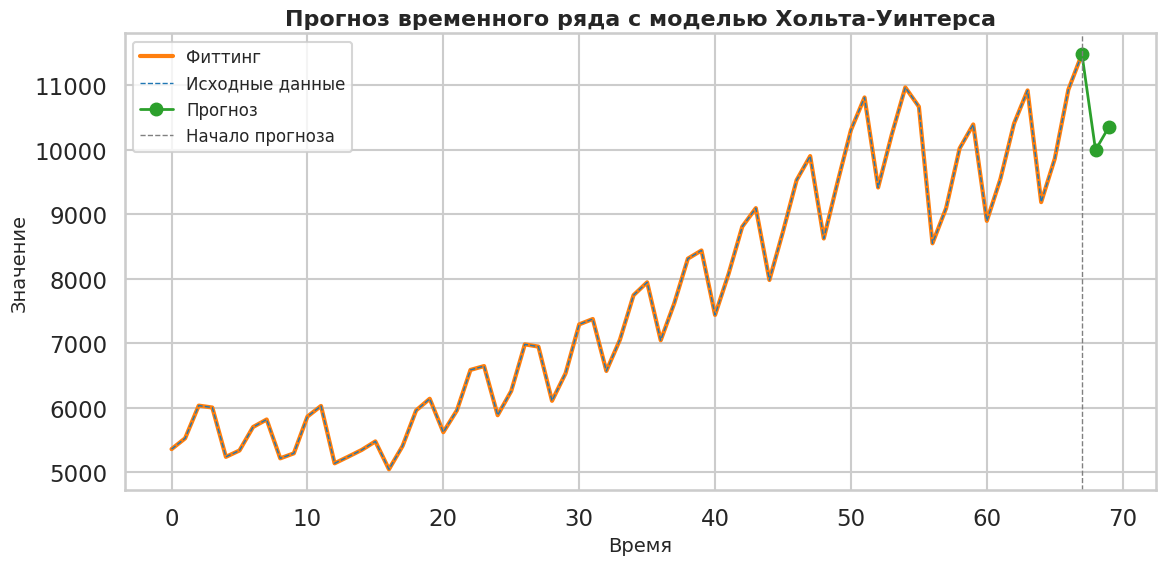

In [93]:
# Генерация данных
season_length = 12
periods = 5
series = data.Value.values

# Тюнинг модели
alpha, beta, gamma = tune_holt_winters(series, season_length, n_preds=2)
print(f"Параметры сглаживания: alpha={alpha:.2f}, beta={beta:.2f}, gamma={gamma:.2f}")

# Прогноз
fitted, forecast = holt_winters_multiplicative(series, alpha, beta, gamma, season_length, n_preds=2)
print(f"Прогноз на следующие периоды: {forecast}")

# Визуализация
sns.set_theme(style="whitegrid", context="talk")
plt.figure(figsize=(12, 6))
plt.plot(fitted, label="Фиттинг", color="tab:orange", linewidth=3)
plt.plot(series, label="Исходные данные", color="tab:blue", linestyle="--", linewidth=1)
plt.plot(range(len(series) - 1, len(series) + len(forecast)), np.insert(forecast, 0, series[-1], axis=0), label="Прогноз", color="tab:green", marker="o", linewidth=2)
plt.title("Прогноз временного ряда с моделью Хольта-Уинтерса", fontsize=16, weight="bold")
plt.xlabel("Время", fontsize=14)
plt.ylabel("Значение", fontsize=14)
plt.axvline(x=len(series) - 1, color="gray", linestyle="--", linewidth=1, label="Начало прогноза")
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

Параметры сглаживания: alpha=0.10, beta=0.10, gamma=0.10
Последнее значение коэффициента сезонности: 1.0570759306253354
Прогноз на следующие периоды: [ 9993.92832762 10359.04634959 11466.23432996 11817.96015894
 10449.33711792 10968.50668317 11970.622912   12095.54969842]


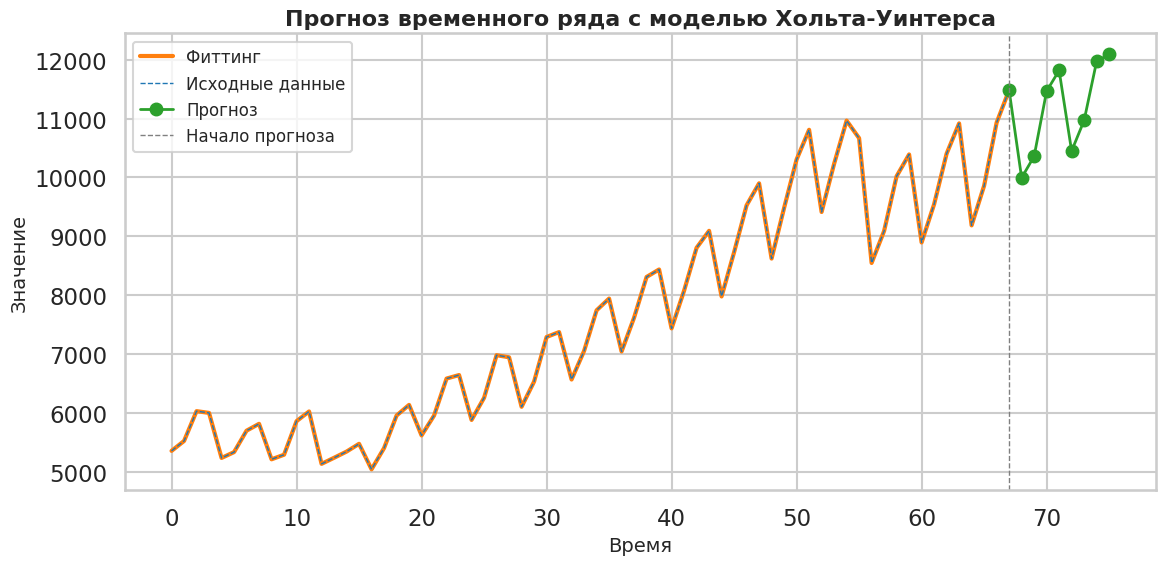

In [94]:
# Генерация данных
season_length = 12
periods = 5
series = data.Value.values

# Тюнинг модели
alpha, beta, gamma = tune_holt_winters(series, season_length, n_preds=8)
print(f"Параметры сглаживания: alpha={alpha:.2f}, beta={beta:.2f}, gamma={gamma:.2f}")

# Прогноз
fitted, forecast = holt_winters_multiplicative(series, alpha, beta, gamma, season_length, n_preds=8)
print(f"Прогноз на следующие периоды: {forecast}")

# Визуализация
sns.set_theme(style="whitegrid", context="talk")
plt.figure(figsize=(12, 6))
plt.plot(fitted, label="Фиттинг", color="tab:orange", linewidth=3)
plt.plot(series, label="Исходные данные", color="tab:blue", linestyle="--", linewidth=1)
plt.plot(range(len(series) - 1, len(series) + len(forecast)), np.insert(forecast, 0, series[-1], axis=0), label="Прогноз", color="tab:green", marker="o", linewidth=2)
plt.title("Прогноз временного ряда с моделью Хольта-Уинтерса", fontsize=16, weight="bold")
plt.xlabel("Время", fontsize=14)
plt.ylabel("Значение", fontsize=14)
plt.axvline(x=len(series) - 1, color="gray", linestyle="--", linewidth=1, label="Начало прогноза")
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

Параметры сглаживания: alpha=0.10, beta=0.10, gamma=0.10
Последнее значение коэффициента сезонности: 1.0719368801403686
Прогноз на следующие периоды: [11349.22169608  9990.29656499 10413.390856   11238.44101985
 11454.85743805]


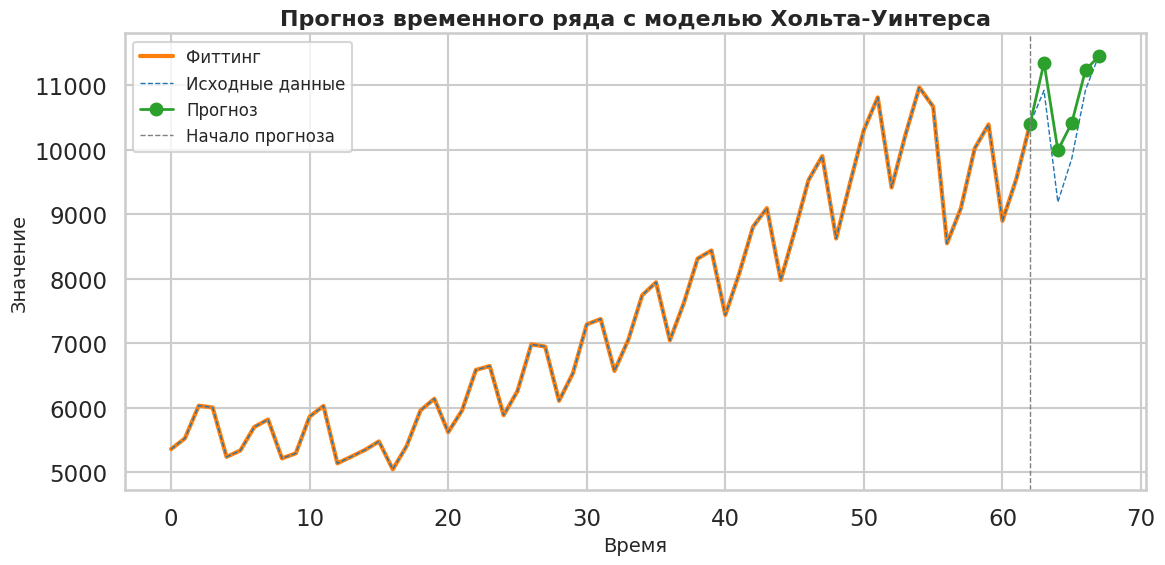

In [95]:
# Генерация данных
season_length = 12
periods = 5
series = data.Value.values[:-5]

# Тюнинг модели
alpha, beta, gamma = tune_holt_winters(series, season_length, n_preds=5)
print(f"Параметры сглаживания: alpha={alpha:.2f}, beta={beta:.2f}, gamma={gamma:.2f}")

# Прогноз
fitted, forecast = holt_winters_multiplicative(series, alpha, beta, gamma, season_length, n_preds=5)
print(f"Прогноз на следующие периоды: {forecast}")

# Визуализация
sns.set_theme(style="whitegrid", context="talk")
plt.figure(figsize=(12, 6))
plt.plot(fitted, label="Фиттинг", color="tab:orange", linewidth=3)
plt.plot(data.Value.values, label="Исходные данные", color="tab:blue", linestyle="--", linewidth=1)
plt.plot(range(len(series) - 1, len(series) + len(forecast)), np.insert(forecast, 0, series[-1], axis=0), label="Прогноз", color="tab:green", marker="o", linewidth=2)
plt.title("Прогноз временного ряда с моделью Хольта-Уинтерса", fontsize=16, weight="bold")
plt.xlabel("Время", fontsize=14)
plt.ylabel("Значение", fontsize=14)
plt.axvline(x=len(series) - 1, color="gray", linestyle="--", linewidth=1, label="Начало прогноза")
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()